Kütüphaneleri içe aktarıyoruz

In [96]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Uyarıların gizlenmesi
import warnings
warnings.filterwarnings("ignore")

Data seti

In [69]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 


Data setinin içeriğini listeliyoruz

In [70]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

PNG dosyalarını ve bunların bulunduğu dizin adlarını toplamak için bu kodu yazarız

In [91]:

label = []
path = []


for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               
            if dir_name.split()[-1]!='GT':                       
                label.append(os.path.split(dir_name)[-1])         
                path.append(os.path.join(dir_name,filename))     

data=pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

Veri yapısını görüntüleme

In [90]:
df = pd.DataFrame({'path': path, 'label': label})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None


df etiketleri çubuk grafikle görselleştirme

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


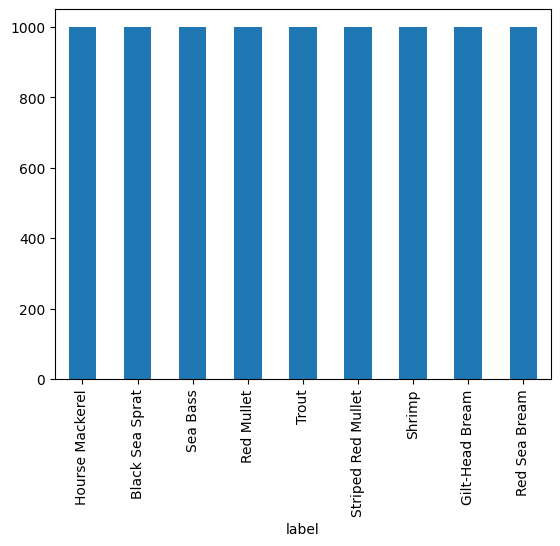

In [73]:
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

Son beş satırı görüntüle

In [74]:
data.tail()

,path,label
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8999,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


Sırayla ilk beş satırı yazdırır,bilgi verir,her bir etiketin kaç kez geçtiğini sayar

In [75]:
print(data.head())
print(data.info())
print(data['label'].value_counts())

                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


Verileri görselleştiriyoruz

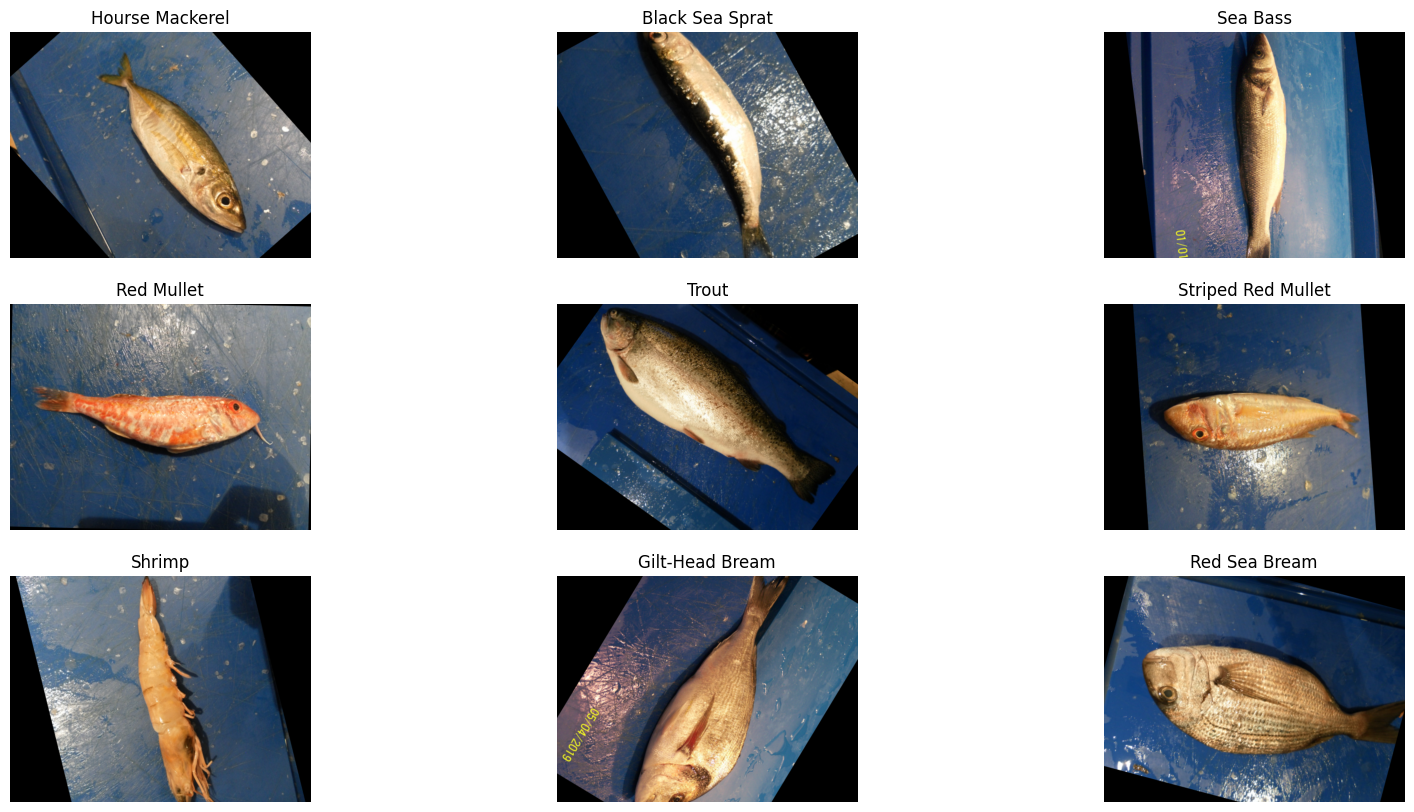

In [76]:
cn = 0
plt.figure(figsize=(20,10))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1


Bu kod, görüntü verilerini ön işlemek ve eğitim/validation setleri oluşturmak için ImageDataGenerator sınıfını kullanır.
ImageDataGenerator: datagen değişkeni, görüntülerin ölçeklendirilmesi için rescale=1./255 ile tanımlanır. Bu, görüntü değerlerini 0 ile 1 arasında normalize eder.
Her görüntü 64x64 olarak ayarlanıyor.




In [92]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_directory(
    fish_dir,
    target_size=(64, 64),  # Görüntü boyutu 64x64 piksel olarak ayarlanıyor
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    fish_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


Sequential ile model tanımlayarak başlarız,giriş katmanındaki verileri flatten ile düzleştirir.Gizli katmanlar için relu aktivasyon fonksiyonunu kullanır.Çıkış katmanı için 'softmax' aktivasyon fonksiyonu ile çıkış verir.Optimize edip verilerin yapısı ve katmanı hakkında modal.summary() bilgi verir.

In [94]:
model = Sequential()

# Giriş katmanı 
model.add(Flatten(input_shape=(64, 64, 3)))

# Gizli katmanlar
model.add(Dense(128, activation='relu'))  
model.add(Dense(64, activation='relu'))   

# Çıkış katmanı
model.add(Dense(train_generator.num_classes, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,833 (6.03 MB)

 Trainable params: 1,581,833 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

Model.fit() fonksiyonu, modelin eğitim verileri (train_generator) ile eğitilmesini sağlar.
validation_data=validation_generator parametresi ile her epoch sonunda modelin performansını değerlendirmek için doğrulama verileri kullanılır.
Epoch Sayısı: epochs=20 ile modelin toplamda 20 defa eğitim verileri üzerinde eğitim alması belirtilir. Her epoch, modelin tüm eğitim verisi üzerinden bir geçiş yapmasını ifade eder.

Sonuçları history değişkeninde saklar, bu sayede eğitim ve doğrulama kayıplarını ve doğruluk değerlerini daha sonra analiz edebilirsiniz.







In [19]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 136s 298ms/step - accuracy: 0.9219 - loss: 0.2200 - val_accuracy: 0.7281 - val_loss: 1.0937
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 136s 298ms/step - accuracy: 0.9241 - loss: 0.2093 - val_accuracy: 0.7072 - val_loss: 1.1412
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 138s 304ms/step - accuracy: 0.9357 - loss: 0.1755 - val_accuracy: 0.6342 - val_loss: 1.8246
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 135s 297ms/step - accuracy: 0.9373 - loss: 0.1786 - val_accuracy: 0.7681 - val_loss: 0.9277
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 298ms/step - accuracy: 0.9521 - loss: 0.1441 - val_accuracy: 0.7003 - val_loss: 1.3815
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 135s 297ms/step - accuracy: 0.9496 - loss: 0.1523 - val_accuracy: 0.6333 - val_loss: 2.0915
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 135s 298ms/step - accuracy: 0.9412 - loss: 0.1643 - val_accuracy: 0.7025 - val_loss: 1.3115
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 135s 296ms/step - accuracy: 0.9579 -

Veri setinin performansını değerlendirir.Model.evaluate(validation_generator) fonksiyonu, modelin doğrulama verileri üzerindeki loss ve accuracy değerlerini hesaplar. Bu, modelin eğitim sırasında öğrendiklerini ne kadar iyi genelleyebildiğini ölçer.
test_loss ve test_acc değişkenleri, modelin kayıp ve doğruluk değerlerini saklar.



In [21]:

test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test doğruluğu: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 408ms/step - accuracy: 0.6879 - loss: 1.9375
Test doğruluğu: 0.6928


Accuracy ve loss değerlerini görselleştirir.

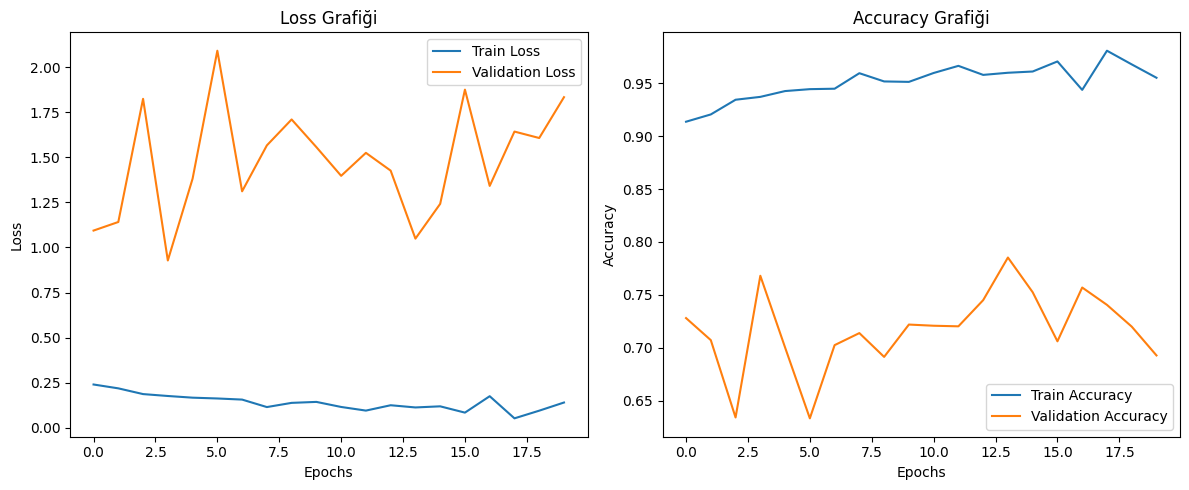

In [67]:

plt.figure(figsize=(12, 5))

# Loss 
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

İlk 4 tahmini ve gerçek etiketleri karşılaştırma 

113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 406ms/step


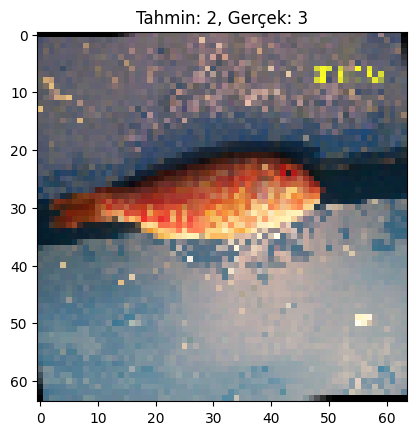

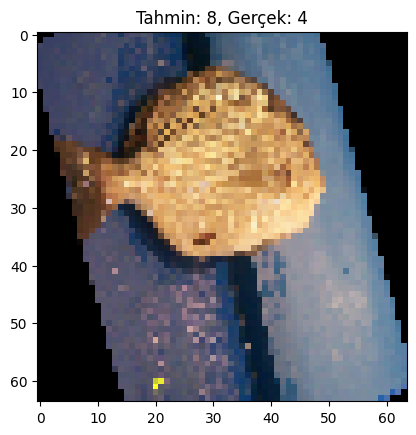

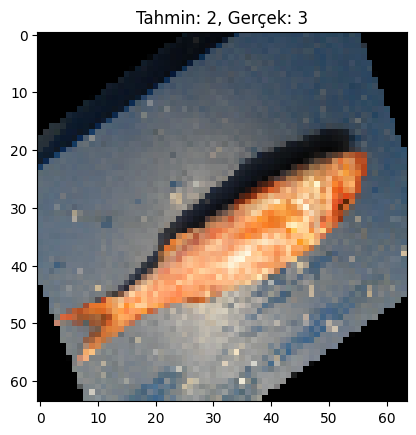

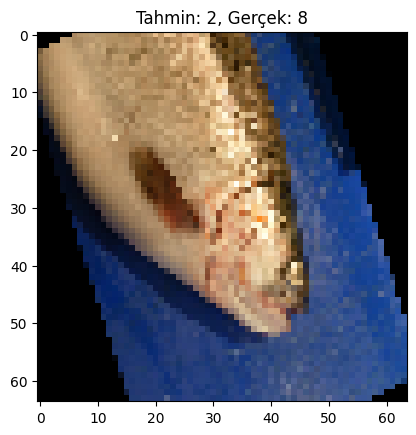

In [46]:

predictions = model.predict(validation_generator)


for i in range(4):
    img, label = validation_generator[i]
    plt.imshow(img[0])
    plt.title(f"Tahmin: {np.argmax(predictions[i])}, Gerçek: {np.argmax(label[0])}")
    plt.show()


Karışıklık matrisi ve sınıflandırma raporu, bir sınıflandırma modelinin performansını değerlendirmek için kullanılır.
Karışıklık matrisi, modelin tahmin ettiği sınıfları ve gerçek sınıfları karşılaştırarak, her sınıf için doğru ve yanlış tahminleri gösteren bir tablodur.
Sınıflandırma raporu, her sınıf için çeşitli performansı  özetler.
Tahminleri ve gerçek etiketleri aldıktan sonra karışıklık matrisi oluşturup,görselleştiririz ve   raporu oluştururuz.



113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 405ms/step


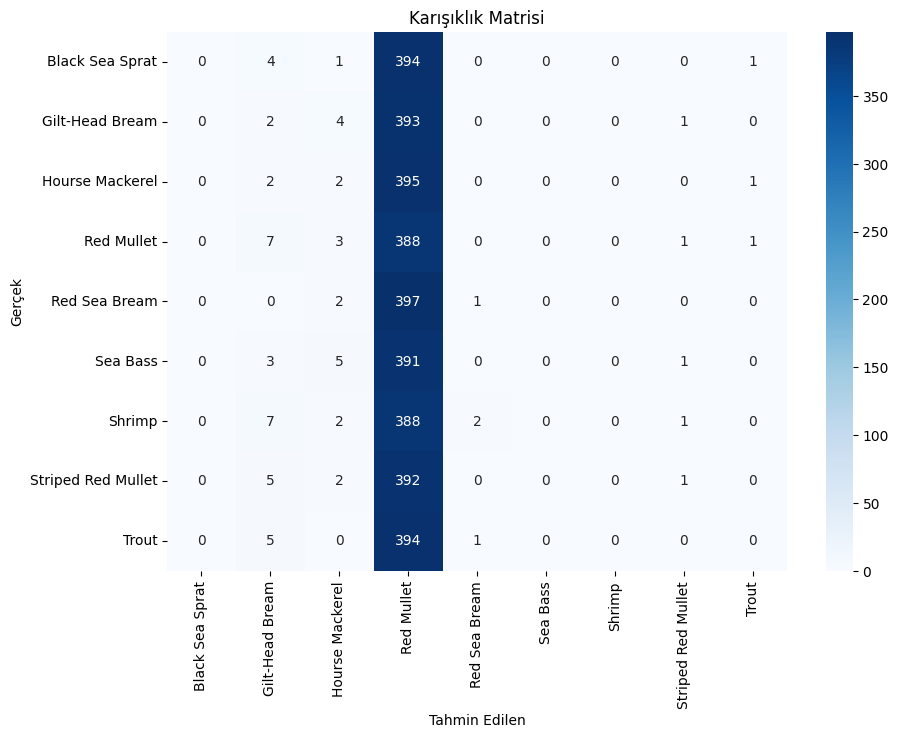

                    precision    recall  f1-score   support

   Black Sea Sprat       0.00      0.00      0.00       400
   Gilt-Head Bream       0.06      0.01      0.01       400
   Hourse Mackerel       0.10      0.01      0.01       400
        Red Mullet       0.11      0.97      0.20       400
     Red Sea Bream       0.25      0.00      0.00       400
          Sea Bass       0.00      0.00      0.00       400
            Shrimp       0.00      0.00      0.00       400
Striped Red Mullet       0.20      0.00      0.00       400
             Trout       0.00      0.00      0.00       400

          accuracy                           0.11      3600
         macro avg       0.08      0.11      0.03      3600
      weighted avg       0.08      0.11      0.03      3600



In [97]:


predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)


true_classes = validation_generator.classes


conf_matrix = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()


report = classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys())
print(report)
